#Importing required libraries for analysis of data

In [61]:
# Import external libraries
import pandas as pd
import numpy as np
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
!pip3 install seaborn==0.9.0
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
sns.set_style('whitegrid')
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE

%matplotlib inline

In [3]:
# Check that version 0.9.0 is loaded for Seaborn
sns.__version__

'0.9.0'

## Importing data from CSV file

In [6]:
# Read churn data from csv
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv") 
# Preview the first 5 lines of the loaded data 
data.drop('customerID',axis=1, inplace=True)
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Processing data

In [8]:
# Convert TotalCharges to numeric values
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
Churn               7043 non-null object
dtypes: float64(2), int64(2), object(16)
memory usage: 1.1+ MB


In [9]:
# Check for NaN values in data
print(data.isna().sum())

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [10]:
# Number of entries with NaN values is negligible (11), drop from data set
data.dropna(inplace=True)
data.shape

(7032, 20)

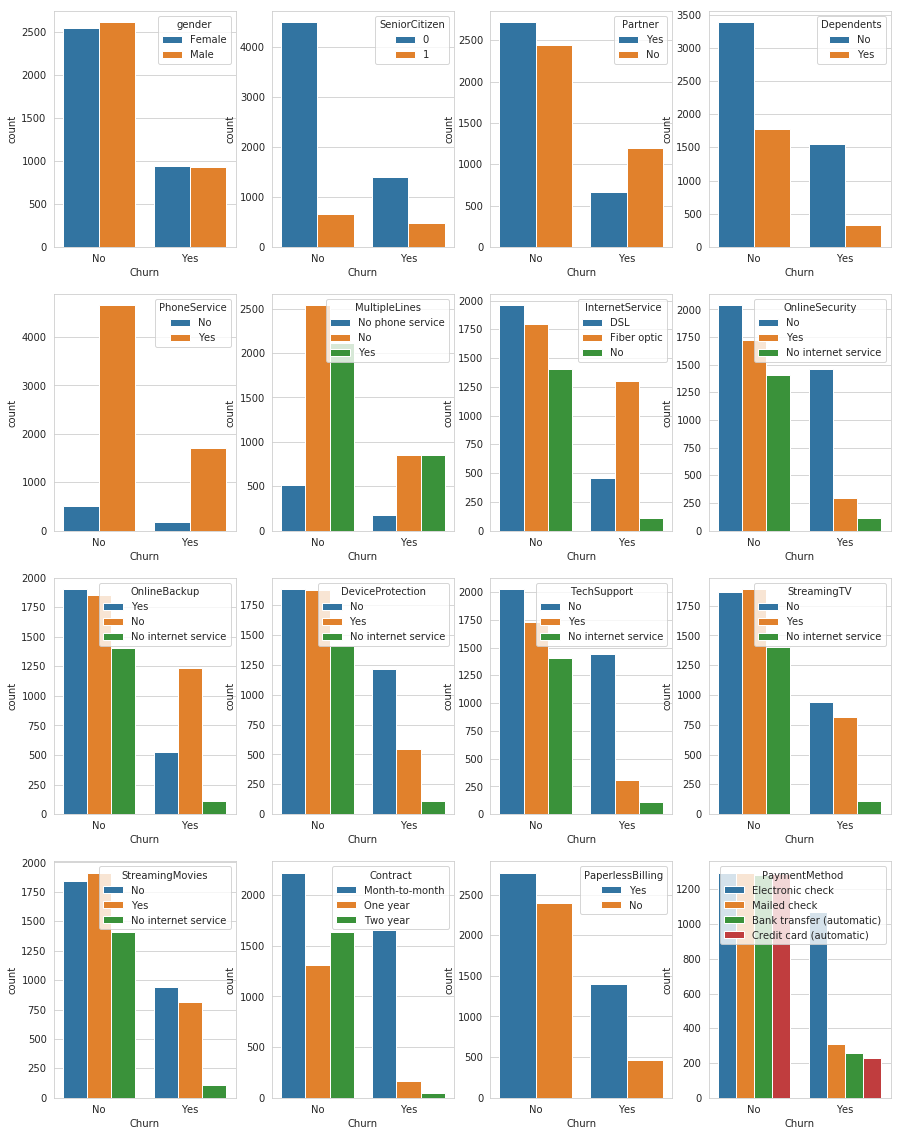

In [11]:
# Plot each feature against Churn to see which may have highest impact
fig,axes = plt.subplots(4,4,squeeze=True,figsize=(15,20))
axes = axes.flatten()

skipped_categories = ['TotalCharges','MonthlyCharges','tenure','Churn']

index = 0
for feature in data.columns:
  # Checking feature distibution on churn
  if feature not in skipped_categories:
    sns.catplot('Churn',data=data,kind='count',hue=feature,ax=axes[index])
    plt.close()
    index += 1
fig.show()


Based on the above charts, it appears that OnlineSecurity, Electronic check payment, Fiber optic internet service, and month-to-month contracts are the most directly tied to churn. We will investigate further though and run correlation on further normalized data.

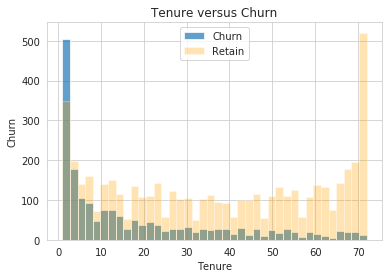

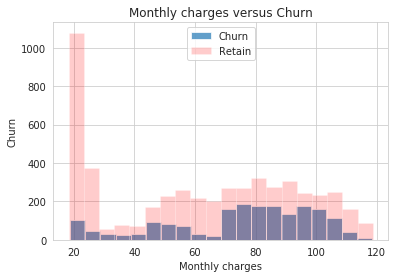

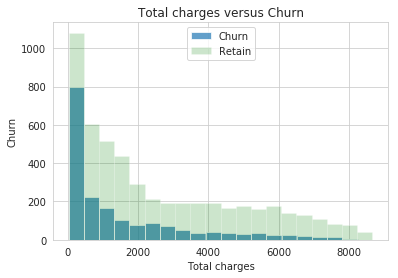

In [12]:
# Create dataframes for customers who did churn (yes_churn) and did not (no_churn)
yes_churn = data[data['Churn']=="Yes"]
no_churn = data[data['Churn']=="No"]

# Plot a histogram against tenure
plt.hist(yes_churn['tenure'],bins=40,alpha=0.7,label="Churn")
plt.hist(no_churn['tenure'],bins=40,alpha=0.3,color='orange',label="Retain")
plt.legend(loc='upper center')
plt.xlabel('Tenure')
plt.ylabel('Churn')
plt.title('Tenure versus Churn')
plt.show()

# Plot a histogram against monthly charges
plt.hist(yes_churn['MonthlyCharges'],bins=20,alpha=0.7,label="Churn")
plt.hist(no_churn['MonthlyCharges'],bins=20,alpha=0.2,color='red',label="Retain")
plt.legend(loc='upper center')
plt.xlabel('Monthly charges')
plt.ylabel('Churn')
plt.title('Monthly charges versus Churn')
plt.show()

# Plot a histogram against total charges
plt.hist(yes_churn['TotalCharges'],bins=20,alpha=0.7,label="Churn")
plt.hist(no_churn['TotalCharges'],bins=20,alpha=0.2,color='green',label="Retain")
plt.legend(loc='upper center')
plt.xlabel('Total charges')
plt.ylabel('Churn')
plt.title('Total charges versus Churn')
plt.show()

Since the total and monthly charges are related, and also impacted by tenure, I wanted to try creating a new feature that calculates the ratio of the monthly charges to the total charges for each customer to see how this might correlate to churn.

(7032, 21)


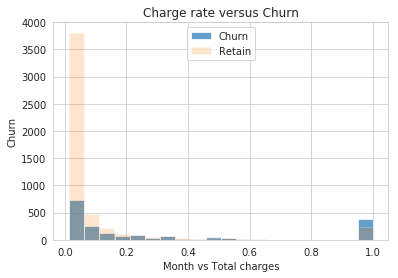

In [15]:
# Create new metric for Monthly versus Total charges
data['month_v_total_charge'] = data['MonthlyCharges']/data['TotalCharges']
print(data.shape)

# Refresh churn data with new metric
yes_churn = data[data['Churn']=="Yes"]
no_churn = data[data['Churn']=="No"]

# Plot a histogram against monthly versus total charges
plt.hist(yes_churn['month_v_total_charge'],bins=20,alpha=0.7,label="Churn")
plt.hist(no_churn['month_v_total_charge'],bins=20,alpha=0.2,label="Retain")
plt.legend(loc='upper center')
plt.xlabel('Month vs Total charges')
plt.ylabel('Churn')
plt.title('Charge rate versus Churn')
plt.show()

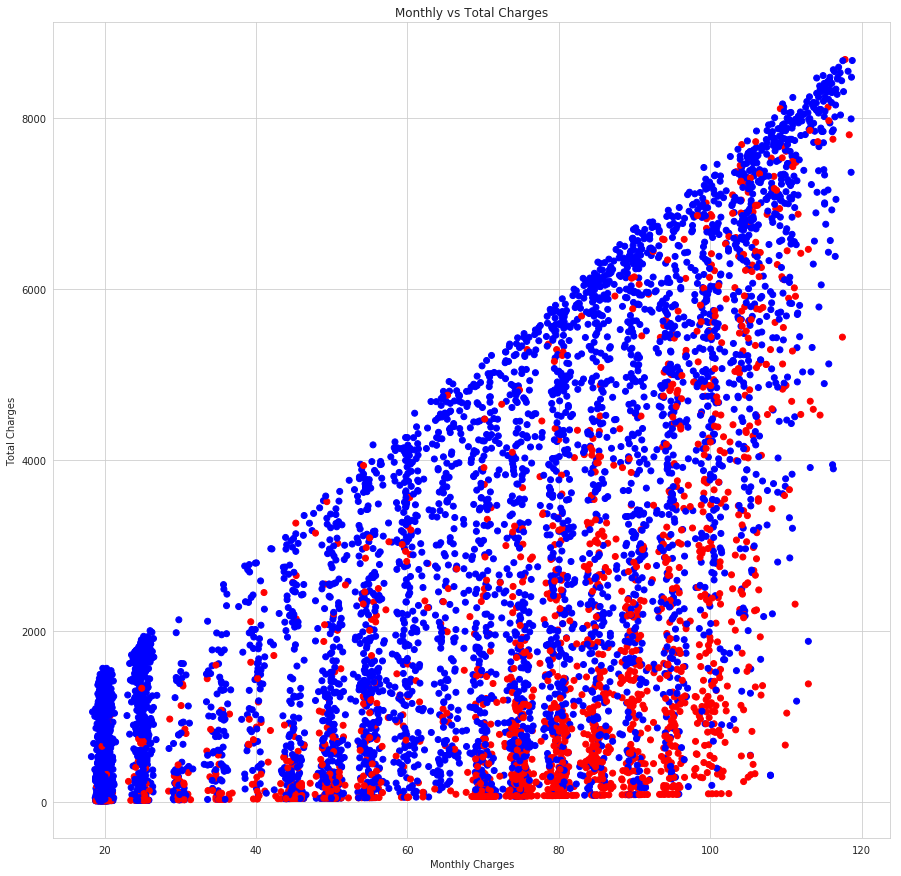

In [18]:
color= ['red' if l == "Yes" else 'blue' for l in data['Churn']]
plt.figure(figsize=(15,15))
plt.scatter(data['MonthlyCharges'],data['TotalCharges'],color=color)
plt.xlabel('Monthly Charges')
plt.ylabel('Total Charges')
plt.title('Monthly vs Total Charges')
plt.show()

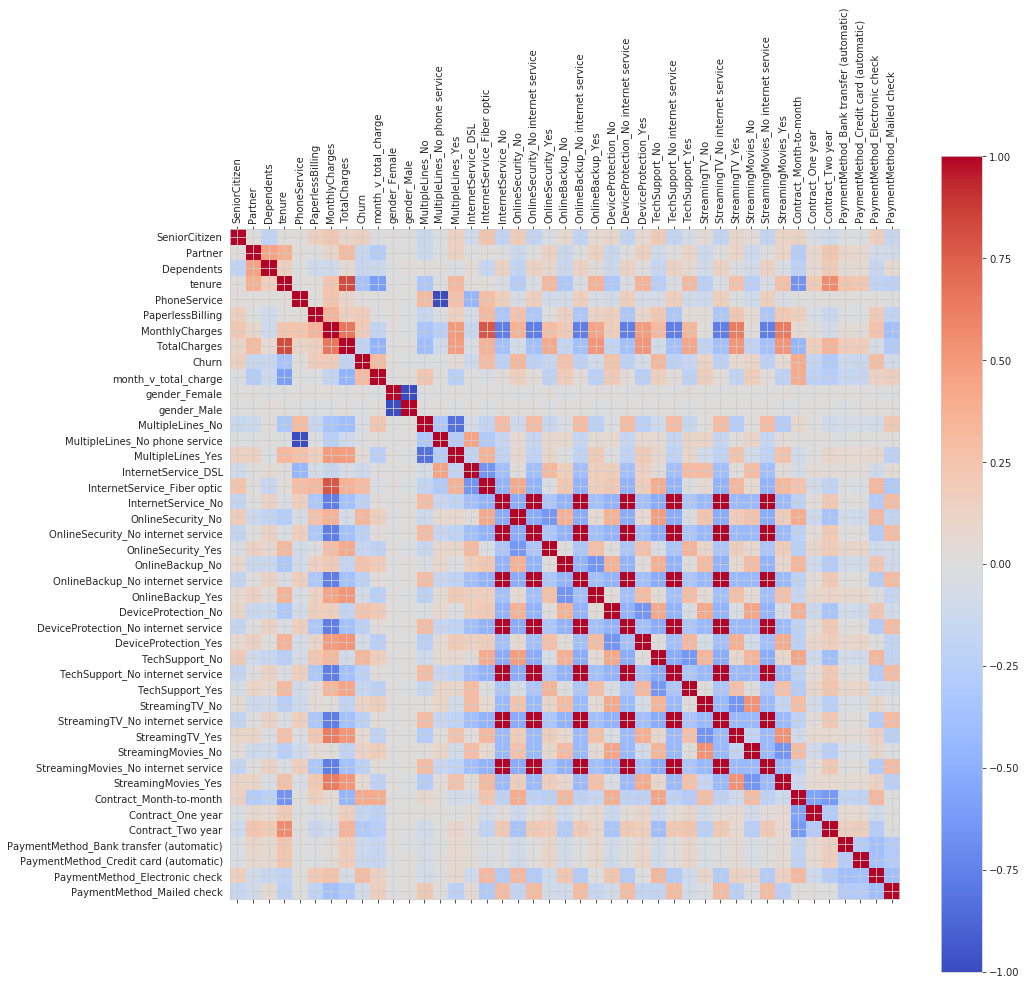

In [21]:
# Encode the data to numeric values for analysis
yes_no_columns = ['Partner','Dependents','PhoneService','PaperlessBilling',
                  'Churn']

dummies_columns = ['gender','MultipleLines','InternetService','OnlineSecurity',
                   'OnlineBackup','DeviceProtection','TechSupport',
                   'StreamingTV','StreamingMovies','Contract','PaymentMethod']

for header in yes_no_columns:
  data[header].replace({"Yes":1,'No':0},inplace=True)

encoded_data = pd.get_dummies(data,columns=dummies_columns)

corr = encoded_data.corr()
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm')
fig.colorbar(cax)
ticks = np.arange(0,len(encoded_data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(encoded_data.columns)
ax.set_yticklabels(encoded_data.columns)
plt.show()

In [29]:
# Print out correlation values for Churn in sorted order
sorted_churn_correlation = corr['Churn'].sort_values(ascending=False)
print(sorted_churn_correlation)

Churn                                      1.000000
Contract_Month-to-month                    0.404565
OnlineSecurity_No                          0.342235
TechSupport_No                             0.336877
month_v_total_charge                       0.318539
InternetService_Fiber optic                0.307463
PaymentMethod_Electronic check             0.301455
OnlineBackup_No                            0.267595
DeviceProtection_No                        0.252056
MonthlyCharges                             0.192858
PaperlessBilling                           0.191454
SeniorCitizen                              0.150541
StreamingMovies_No                         0.130920
StreamingTV_No                             0.128435
StreamingTV_Yes                            0.063254
StreamingMovies_Yes                        0.060860
MultipleLines_Yes                          0.040033
PhoneService                               0.011691
gender_Female                              0.008545
gender_Male 

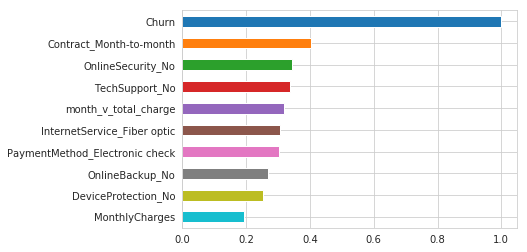

In [31]:
(pd.Series(sorted_churn_correlation, index=encoded_data.columns)
   .nlargest(10)
   .plot(kind='barh')
   .invert_yaxis())

This confirms that the top contributing factors to churn are:

 1) Month-to-month contract
 
 2) No online security
 
 3) No tech support
 
 4) Monthly versus total charge amounts
 
 5) Fiber optic internet service

## Creating test, training, and validation sets from the processed data

In [84]:
# First, create separate dataframes for features and labels
features = encoded_data.copy()
features.drop(columns=['Churn'],inplace=True)
labels = encoded_data['Churn']

# Next split out the test set that will be held out until final evaluation
features_train,features_test,labels_train,labels_test = train_test_split(
  features, labels, test_size=0.2, shuffle=True)
features_train,features_validate,labels_train,labels_validate = train_test_split(
  features_train, labels_train, test_size=0.2, shuffle=True)

print("Shape of training feature set is ",features_train.shape)

Shape of training feature set is  (4500, 42)


In [85]:
# Check distribution of churn among data sets
print("Percentage of training data with churn =",
      sum(labels_train == 1)/len(labels_train))
print("Percentage of validation data with churn =",
      sum(labels_validate == 1)/len(labels_validate))
print("Percentage of test data with churn = ",
      sum(labels_test == 1)/len(labels_test))

# Look at churn entries for training set
print("Training set churn count = ",sum(labels_train == 1))
print("Training set retention count = ",sum(labels_train == 0))
print("Validation set churn count = ",sum(labels_validate == 1))
print("Validation set retention count = ",sum(labels_validate == 0))

Percentage of training data with churn = 0.2653333333333333
Percentage of validation data with churn = 0.2604444444444444
Percentage of test data with churn =  0.27149964463397297
Training set churn count =  1194
Training set retention count =  3306
Validation set churn count =  293
Validation set retention count =  832


## Balance data for training set

In [86]:
# Use the SMOTE package to synthetically create additional instances of minority
sm = SMOTE(random_state=42)
bal_features_train,bal_labels_train = sm.fit_resample(features_train,labels_train)
print("Balanced training set churn count = ",sum(bal_labels_train == 1))
print("Balanced training set retention count = ",sum(bal_labels_train == 0))

Balanced training set churn count =  3306
Balanced training set retention count =  3306


## Train and test models

In [114]:
# Gaussian and Bernoulli Naive Bayes models and logistic regression model from scikitlearn 
gnb = GaussianNB()
bnb = BernoulliNB()
LogReg = LogisticRegression(solver='liblinear')
RanFor = RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42)

# K-Folds cross-validator for model selection from scikitlearn
kf = KFold(n_splits=5)
bnb_accuracy = []
gnb_accuracy = []
log_accuracy = []
ran_accuracy = []

# Function to evaluate the accuracy of all three models given the indices of the train and test subset
def evaluate(train_indices, test_indices):
    X_train = bal_features_train[train_indices]
    Y_train = bal_labels_train[train_indices]
    X_test = bal_features_train[test_indices]
    Y_test = bal_labels_train[test_indices]
    gnb_pred = gnb.fit(X_train, Y_train)
    gnb_acc = gnb_pred.score(X_test, Y_test)
    gnb_accuracy.append(gnb_acc)
    bnb_pred = bnb.fit(X_train, Y_train)
    bnb_acc = bnb_pred.score(X_test, Y_test)
    bnb_accuracy.append(bnb_acc)
    log_pred = LogReg.fit(X_train, Y_train)
    log_acc = log_pred.score(X_test, Y_test)
    log_accuracy.append(log_acc)
    ran_pred = RanFor.fit(X_train, Y_train)
    ran_acc = ran_pred.score(X_test, Y_test)
    ran_accuracy.append(ran_acc)
    print("Predicted gnb accuracy = ", gnb_acc)
    print("Predicted bnb accuracy = ", bnb_acc)
    print("Predicted logistic regression accuracy = ", log_acc)
    print("Predicted random forest accuracy = ", ran_acc)

# Perform the evaluate function on the k-fold indices
for train_index, test_index in kf.split(bal_labels_train):
  print("----------- Evaluation data -----------")
  evaluate(train_index, test_index)
 
print("========== Average accuracies ===========")
print("BNB = ",sum(bnb_accuracy)/len(bnb_accuracy))
print("GNB = ",sum(gnb_accuracy)/len(gnb_accuracy))
print("LOG = ",sum(log_accuracy)/len(log_accuracy))
print("RAN = ",sum(ran_accuracy)/len(ran_accuracy))

----------- Evaluation data -----------
Predicted gnb accuracy =  0.7097505668934241
Predicted bnb accuracy =  0.6976568405139834
Predicted logistic regression accuracy =  0.7256235827664399
Predicted random forest accuracy =  0.762660619803477
----------- Evaluation data -----------
Predicted gnb accuracy =  0.7105064247921391
Predicted bnb accuracy =  0.7112622826908541
Predicted logistic regression accuracy =  0.7339380196523053
Predicted random forest accuracy =  0.7838246409674982
----------- Evaluation data -----------
Predicted gnb accuracy =  0.6936459909228442
Predicted bnb accuracy =  0.6989409984871406
Predicted logistic regression accuracy =  0.7344931921331316
Predicted random forest accuracy =  0.7692889561270801
----------- Evaluation data -----------
Predicted gnb accuracy =  0.7912254160363086
Predicted bnb accuracy =  0.8040847201210287
Predicted logistic regression accuracy =  0.7556732223903178
Predicted random forest accuracy =  0.8857791225416036
----------- Evalu

In [115]:
# Check accuracy against validation set
gnb_pred = gnb.fit(bal_features_train, bal_labels_train)
bnb_pred = bnb.fit(bal_features_train, bal_labels_train)
log_pred = LogReg.fit(bal_features_train, bal_labels_train)
ran_pred = RanFor.fit(bal_features_train, bal_labels_train)
print("Gaussian naive bayes accuracy against validation data:\n",
     gnb_pred.score(features_validate, labels_validate))
print("Bernoulli naive bayes accuracy against validation data:\n",
     bnb_pred.score(features_validate, labels_validate))
print("Logistic regression accuracy against validation data:\n",
     log_pred.score(features_validate, labels_validate))
print("Random forest accuracy against validation data:\n",
     ran_pred.score(features_validate, labels_validate))


Gaussian naive bayes accuracy against validation data:
 0.7217777777777777
Bernoulli naive bayes accuracy against validation data:
 0.7182222222222222
Logistic regression accuracy against validation data:
 0.7751111111111111
Random forest accuracy against validation data:
 0.8017777777777778


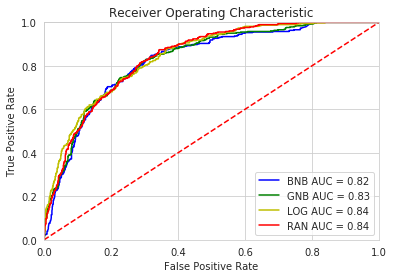

In [116]:
# Plot ROC curve for each model
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Plot ROC curve for Bernoulli Naive Bayes
bnb_prob = bnb.predict_proba(features_test)
fpr, tpr, threshold = metrics.roc_curve(labels_test, bnb_prob[:,1])
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'BNB AUC = %0.2f' % roc_auc)

# Plot ROC curve for Gaussian Naive Bayes
gnb_prob = gnb.predict_proba(features_test)
fpr, tpr, threshold = metrics.roc_curve(labels_test, gnb_prob[:,1])
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'g', label = 'GNB AUC = %0.2f' % roc_auc)

# Plot ROC curve for Logistic Regression
log_prob = LogReg.predict_proba(features_test)
fpr, tpr, threshold = metrics.roc_curve(labels_test, log_prob[:,1])
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'y', label = 'LOG AUC = %0.2f' % roc_auc)

# Plot ROC curve for Random Forest
ran_prob = RanFor.predict_proba(features_test)
fpr, tpr, threshold = metrics.roc_curve(labels_test, ran_prob[:,1])
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'r', label = 'RAN AUC = %0.2f' % roc_auc)

plt.legend(loc = 'lower right')

plt.show()

In [117]:
print("Gaussian naive bayes accuracy against held out test data:\n",
     gnb_pred.score(features_test, labels_test))
print("Bernoulli naive bayes accuracy against held out test data:\n",
     bnb_pred.score(features_test, labels_test))
print("Logistic regression accuracy against held out test data:\n",
     log_pred.score(features_test, labels_test))
print("Random forest accuracy against held out test data:\n",
     ran_pred.score(features_test, labels_test))

Gaussian naive bayes accuracy against held out test data:
 0.7057569296375267
Bernoulli naive bayes accuracy against held out test data:
 0.7192608386638237
Logistic regression accuracy against held out test data:
 0.7313432835820896
Random forest accuracy against held out test data:
 0.7697228144989339


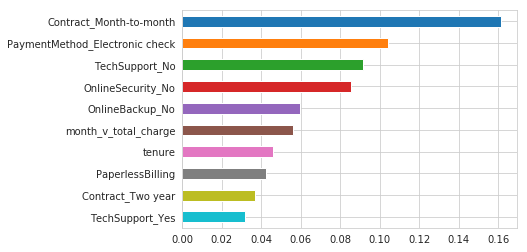

In [120]:
(pd.Series(RanFor.feature_importances_, index=features_train.columns)
   .nlargest(10)
   .plot(kind='barh')
   .invert_yaxis())

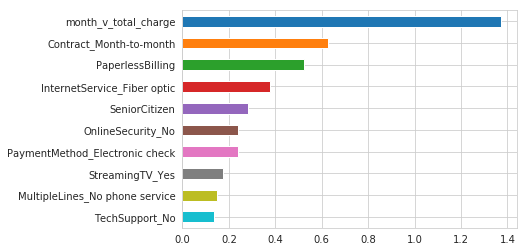

In [132]:
(pd.Series(LogReg.coef_[0], index=features_train.columns)
   .nlargest(10)
   .plot(kind='barh')
   .invert_yaxis())


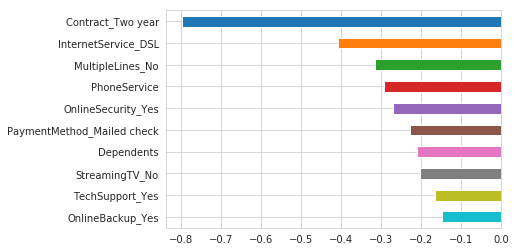

In [133]:
(pd.Series(LogReg.coef_[0], index=features_train.columns)
   .nsmallest(10)
   .plot(kind='barh')
   .invert_yaxis())